### statis

In [ ]:
import pandas as pd


### vi_squad

In [34]:
%cd /home/tuyendv/Desktop/reranker
import json
import pandas as pd
from bm25 import BM25
from underthesea import word_tokenize
from tqdm import tqdm
from utils import save_data

/home/tuyendv/Desktop/reranker


In [39]:
path = "/home/tuyendv/Desktop/reranker/data/vinai/train-v2.0-translated.json"
data = json.load(open(path, "r", encoding="utf-8"))

df = pd.DataFrame(data, columns=["passage", "query", "answer"])
df.head()

,passage,query,answer
0,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Beyonce bắt đầu nổi tiếng từ khi nào?,Vào cuối những năm 1990
1,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Beyonce đã cạnh tranh trong lĩnh vực nào khi c...,Hát và nhảy múa
2,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Beyonce rời Destiny's Child và trở thành ca sĩ...,2003
3,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Beyonce lớn lên ở thành phố và tiểu bang nào?,Houston Khách sạn
4,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Beyonce nổi tiếng trong thập kỷ nào?,Cuối những năm 1990


In [40]:
passages = []
for i, doc in enumerate(df.passage.unique().tolist()):
    _id = str(i).zfill(6)
    _text = doc
    
    passages.append([_id, _text])
    
passages = pd.DataFrame(passages, columns=["id", "passage_text"])
passages.head()

,id,passage_text
0,000000,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...
1,000001,Sau sự tan rã của Destiny's Child vào tháng 6 ...
2,000002,"Là một ""nữ quyền hiện đại ngày nay"", Beyoncé t..."
3,000003,Beyoncé Giselle Knowles được sinh ra ở Houston...
4,000004,Beyoncé theo học tại trường tiểu học St. Mary ...


In [41]:
bm25 = BM25()
bm25.train(passages)

In [42]:
data = []
for index in tqdm(df.index):
    query = df["query"][index]
    positive_passage = df["passage"][index]
    all_passage = bm25.ranking(positive_passage, top_k=8)["retrieval_text"].tolist()
    
    passages = []
    mark = 0
    for passage in all_passage:
        if positive_passage == passage:
            sample = {
                "is_selected":1,
                "passage_text":passage
            }
            mark = 1
        else:
            sample = {
                "is_selected":0,
                "passage_text":passage
            }
        passages.append(sample)
        
    if mark == 0:
        sample = {
            "is_selected":1,
            "passage_text":positive_passage
        }
        passages.append(sample)
    
    data.append(
        {
            "query":query,
            "passages":passages
        }
    )

100%|██████████| 130319/130319 [52:16<00:00, 41.55it/s] 


In [44]:
path = "/home/tuyendv/Desktop/reranker/data/squad-en/vinai-train-v2.0-translated.json"
save_data(path, data=data)

### vi_data

In [ ]:
import pandas as pd
import json

In [ ]:
path = "/home/tuyendv/Desktop/reranker/data/raw/vi_data.json"
df = pd.read_json(path)
df.head()

In [ ]:
data = []
for index in df.index:
    query = df["question"][index]
    positive = df["positive_sample"][index]
    negative_samples = df["negative_samples"][index]
    
    passages = []
    
    passages.append(
        {
            "passage_text":positive,
            "is_selected":1
        }
    )
    
    for negative in negative_samples:
        passages.append(
            {
                "passage_text":negative,
                "is_selected":0
            }
        )
        
    data.append(
        {
            "query":query,
            "passages":passages
        }
    )

In [ ]:
def save_data(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for sample in data:
            json_obj = json.dumps(sample, ensure_ascii=False)
            f.write(json_obj+"\n")

path="/home/tuyendv/Desktop/reranker/data/ir/vi_data.json"
save_data(path, data)

### v1

In [1]:
import json

In [5]:
path = "/home/tuyendv/Desktop/reranker/data/ir/train/ms-macro-train_v1.1.json"

data = []
with open(path, "r", encoding="utf-8") as f:
    for line in f.readlines():
        line = json.loads(line.strip())
        passages = [
            {
                "passage_text":i["passage_text"],
                "is_selected":i["is_selected"]
                } for i in line["passages"]
            ]
        data.append(
            {
                "query":line["query"],
                "passages":passages
            }
        )

In [4]:
def save_data(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for sample in data:
            json_obj = json.dumps(sample, ensure_ascii=False)
            f.write(json_obj+"\n")

path = "/home/tuyendv/Desktop/reranker/data/ir/train/ms-macro-train_v1.1.json"
save_data(path, data[0:30000])

### temp

In [3]:
%cd /home/tuyendv/Desktop/reranker/
import os 
from glob import glob
import json
import pandas as pd
from utils import load_data

/home/tuyendv/Desktop/reranker


In [13]:
path = "/home/tuyendv/Desktop/reranker/data/ir/test"
data = load_data(path)
data = [json.loads(line) for line in data]
len(data)

614

In [14]:
data= pd.DataFrame(data)
data.head()

,query,passages
0,Tập đoàn Vingroup được thành lập vào ngày nào?,[{'passage_text': 'nhất thế giới (Brand Financ...
1,Tiền thân của Vingroup là công ty nào và chuy...,[{'passage_text': 'và giá trị gia tăng Tập đoà...
2,Thương hiệu mỳ của Vingroup được mua lại bởi ...,[{'passage_text': 'cảnh báo Trung tâm Đo kiểm ...
3,Công ty cổ phần Vinpearl và công ty cổ phần V...,[{'passage_text': 'ty cổ phần Dịch vụ gia Tập ...
4,Cổ phiếu Vingroup phát hành thêm cho mục đích...,[{'passage_text': 'giải pháp hệ thống nhận diệ...


In [15]:
def get_length(query, passages):
    query_length = len(query.split())
    
    lengths = []
    for pa in passages:
        tmp = pa["passage_text"]
        
        lengths.append(len(tmp.split()) + query_length)
        
    return lengths

data["length"] = data.apply(lambda x: get_length(x["query"], x["passages"]), axis=1)

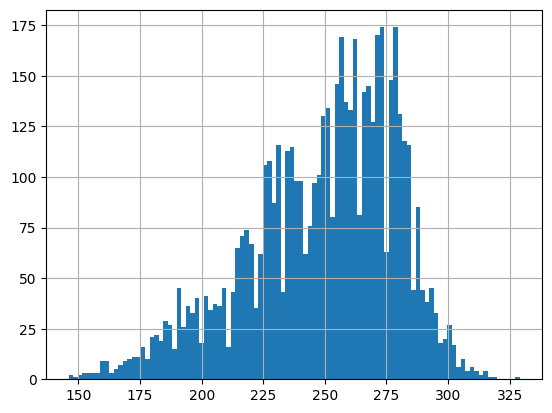

In [16]:
lengths = [i for j in data.length.tolist() for i in j]
pd.DataFrame(lengths, columns=["lengths"]).lengths.hist(bins=100)